In [ ]:
import cv2
import glob
import numpy as np
import math
import traceback
import sys
from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.cluster import KMeans

# **Helper Functions**

### **Solving the puzzle**

In [ ]:
def is_right_angle(points):

    a = np.array(points[0])
    b = np.array(points[1])
    c = np.array(points[2])

    ba = a-b
    bc = c-b

    np.dot(ba, bc)
    np.linalg.norm(ba)
    np.linalg.norm(bc)
    cos_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cos_angle)

    angle_diff = abs(math.pi/2 - angle)
    # print("angle: " + str(angle) + " " + str(angle_diff))
    return angle_diff < .02

In [ ]:
def find_corners(mask, img, points):

    #print("STATUS: finding corners...")
    # print(points)

    if len(points) < 4:
        print("ERROR: not enough points")
        print("could not find corners")
        cv2_imshow(img)
        print("mask")
        cv2_imshow(mask)
        cv2.waitKey()
        sys.exit()
    corners = []

    curr = 0
    while len(corners) < 4:
        if curr >= len(points):
            print("ERROR: not enough points")
            print("could not find corners")
            cv2_imshow(img)
            print("mask")
            cv2_imshow(mask)
            cv2.waitKey()
            sys.exit()
        corners = []
        if is_right_angle([points[curr%len(points)], points[(curr+1)%len(points)],
            points[(curr+2)%len(points)]]):

            corners.insert(len(corners), points[curr%len(points)])
            corners.insert(len(corners), points[(curr+1)%len(points)])
            corners.insert(len(corners), points[(curr+2)%len(points)])

            if is_right_angle([points[(curr+1)%len(points)], points[(curr+2)%len(points)],
            points[(curr+3)%len(points)]]):
                corners.insert(len(corners), points[(curr + 3) % len(points)])
            elif is_right_angle([points[(curr+1)%len(points)], points[(curr+2)%len(points)],
            points[(curr+4)%len(points)]]):
                corners.insert(len(corners), points[(curr + 4) % len(points)])

        elif is_right_angle([points[curr%len(points)], points[(curr+1)%len(points)],
            points[(curr+3)%len(points)]]):

            corners.insert(len(corners), points[curr%len(points)])
            corners.insert(len(corners), points[(curr+1)%len(points)])
            corners.insert(len(corners), points[(curr+3)%len(points)])

            if is_right_angle([points[(curr+1)%len(points)], points[(curr+3)%len(points)],
            points[(curr+4)%len(points)]]):
                corners.insert(len(corners), points[(curr + 4) % len(points)])
            elif is_right_angle([points[(curr+1)%len(points)], points[(curr+3)%len(points)],
            points[(curr+5)%len(points)]]):
                corners.insert(len(corners), points[(curr + 5) % len(points)])

        elif is_right_angle([points[curr%len(points)], points[(curr+2)%len(points)],
            points[(curr+3)%len(points)]]):

            corners.insert(len(corners), points[curr%len(points)])
            corners.insert(len(corners), points[(curr+2)%len(points)])
            corners.insert(len(corners), points[(curr+3)%len(points)])

            if is_right_angle([points[(curr+2)%len(points)], points[(curr+3)%len(points)],
            points[(curr+4)%len(points)]]):
                corners.insert(len(corners), points[(curr + 4) % len(points)])
            elif is_right_angle([points[(curr+2)%len(points)], points[(curr+3)%len(points)],
            points[(curr+5)%len(points)]]):
                corners.insert(len(corners), points[(curr + 5) % len(points)])

        elif is_right_angle([points[curr%len(points)], points[(curr+2)%len(points)],
            points[(curr+4)%len(points)]]):

            corners.insert(len(corners), points[curr%len(points)])
            corners.insert(len(corners), points[(curr+2)%len(points)])
            corners.insert(len(corners), points[(curr+4)%len(points)])

            if is_right_angle([points[(curr+2)%len(points)], points[(curr+4)%len(points)],
            points[(curr+5)%len(points)]]):
                corners.insert(len(corners), points[(curr + 5) % len(points)])
            elif is_right_angle([points[(curr+2)%len(points)], points[(curr+4)%len(points)],
            points[(curr+6)%len(points)]]):
                corners.insert(len(corners), points[(curr + 6) % len(points)])

        if len(corners) < 4:
            corners = []
        curr += 1

    # print("STATUS: corners found")
    # print(corners)
    return corners

In [ ]:
def order_corners(corners):
    corners = np.array(corners)
    x_sort = corners[np.argsort(corners[:, 0]), :]

    left_pair = x_sort[:2, :]
    right_pair = x_sort[2:, :]

    left_pair = left_pair[np.argsort(left_pair[:, 1]), :]
    (top_left, bottom_left) = left_pair

    right_pair = right_pair[np.argsort(right_pair[:, 1]), :]
    (top_right, bottom_right) = right_pair

    return [top_left, top_right, bottom_right, bottom_left]

In [ ]:
def rotate_img(img, angle):
    center = tuple(np.array(img.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    res = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    return res

In [ ]:
def point_equals(point0, point1):
    if point0[0] == point1[0] and point0[1] == point1[1]:
        return True
    else:
        return False

In [ ]:
def order_pts_clockwise(points, orig):

    # realign points to start from top_left corner
    # (end from top_left, then reorder)
    while not point_equals(points[len(points)-1], orig):
        points.append(points.pop(0))

    points.reverse()
    return points

In [ ]:
def is_corner(point, corners):
    for corner in corners:
        if point_equals(point, corner):
            return True
    return False

In [ ]:
def calculateAngle(pts):

    a = np.array(pts[0])
    b = np.array(pts[1])
    c = np.array(pts[2])

    ba = a - b
    bc = c - b

    cos_angle = np.dot(ba,bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cos_angle)

    return angle

In [ ]:
def triangle_area(a, b, c):
    l1 = math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)
    l2 = math.sqrt((b[0] - c[0])**2 + (b[1] - c[1])**2)
    l3 = math.sqrt((c[0] - a[0])**2 + (c[1] - a[1])**2)
    s = (l1 + l2 + l3) / 2
    area = math.sqrt(s * (s-l1) * (s-l2) * (s-l3))
    return area

def rect_area(corners):
    w = math.hypot(corners[1][0] - corners[0][0], corners[1][1] - corners[0][1])
    h = math.hypot(corners[2][0] - corners[1][0], corners[2][1] - corners[1][1])
    return w*h

def point_in_rect(point, corners):
    apd = triangle_area(corners[0], point, corners[3])
    dpc = triangle_area(corners[3], point, corners[2])
    cpb = triangle_area(corners[2], point, corners[1])
    pba = triangle_area(corners[1], point, corners[0])

    # print("sum: " + str(apd + dpc + cpb + pba) + " vs. rect: " + str(rect_area(corners)))
    rect = rect_area(corners)

    if (apd + dpc + cpb + pba - rect) > rect/400:
        return False
    return True

In [ ]:
class Edge:
    lengths = []
    angle = 0
    edge_type = 0    # 0 if f, 1 is m
    side = 0    # 0 is top_left, clockwise from there
    piece_id = 0
    color = 0
    corner_colors = []
    label = -1
    depth = 0

    def __init__(self, lengths, angle, edge_type, side, piece_id, color, corner_colors, depth):
        self.lengths = lengths
        self.angle = angle
        self.edge_type = edge_type
        self.side = side
        self.piece_id = piece_id
        self.color = color
        self.corner_colors = corner_colors
        self.depth = depth

    def set_label(self, label):
        self.label = label

In [ ]:
class Piece:
    points = []
    corners = []
    edges = []
    type = 0 # 0 for interior, 1 for edge, 2 for corner
    id = 0
    image = []
    mask = []

    # order: top-left clockwise
    def __init__(self, ordered_points, corners, index, type, image, mask):
        self.points = ordered_points
        self.corners = corners
        self.id = index
        self.image = image
        self.mask = mask
        self.edges = []
        self.type = type
        self.clockwise_rotation = 0

        i = 0
        side = 0
        while i < len(self.points):
            if not is_corner(self.points[(i+1)%len(self.points)], self.corners):
                first = i
                second = (i+1) % len(self.points)
                third = (i+2) % len(self.points)

                l_dist = np.linalg.norm(np.array(self.points[first])-np.array(self.points[second]))
                r_dist = np.linalg.norm(np.array(self.points[second])-np.array(self.points[third]))
                angle = calculateAngle([self.points[first], self.points[second],
                    self.points[third]])
                if side % 2 == 0:
                    depth = abs(self.points[first][1] - self.points[second][1])
                else:
                    depth = abs(self.points[first][0] - self.points[second][0])

                edge_type = 0
                if not point_in_rect(self.points[second], corners):
                    edge_type = 1

                x, y = self.points[second]
                color = image[y][x]

                corner_colors = [0, 0]
                x1, y1 = self.points[first]
                x2, y2 = self.points[third]
                corner_colors[0] = image[y1][x1]
                corner_colors[1] = image[y2][x2]

                self.edges.append(Edge([l_dist, r_dist], angle, edge_type,
                    side, self.id, color, corner_colors, depth))
                i += 2
            else:
                i += 1
            side += 1

    def get_edge(self, side):
        for edge in self.edges:
            if edge.side == side:
                return edge
        return None

    def get_edge_type(self, side):
        for edge in self.edges:
            if edge.side == side:
                return edge.edge_type
        return -1

    # NOTE: points and corners are not used at the stage where this is used
    #       so there is no need to rotate them
    def rotate(self, num_rotations):
        if num_rotations == 1:
            self.image = cv2.rotate(self.image, cv2.ROTATE_90_CLOCKWISE)
            self.mask = cv2.rotate(self.mask, cv2.ROTATE_90_CLOCKWISE)
        elif num_rotations == 2:
            self.image = cv2.rotate(self.image, cv2.ROTATE_180)
            self.mask = cv2.rotate(self.mask, cv2.ROTATE_180)
        elif num_rotations == 3:
            self.image = cv2.rotate(self.image, cv2.ROTATE_90_COUNTERCLOCKWISE)
            self.mask = cv2.rotate(self.mask, cv2.ROTATE_90_COUNTERCLOCKWISE)

        for edge in self.edges:
            edge.side = edge.side + num_rotations
            edge.side = edge.side % 4

    def mask_image(self):
        x, y, w, h = cv2.boundingRect(self.mask)
        img = self.image[y:y+h, x:x+w]
        return img

    def offset(self, side):
        edge = self.get_edge(side)
        if edge is not None:
            return edge.depth
        return 0

### **Process Image**

In [ ]:
def processImg(img, index):
    # Convert image to grayscale and invert colors
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = 255 - gray

    # Find the largest contour in the image
    mask = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    eps = 0.01 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, eps, True)
    cv2.drawContours(mask, [approx], 0, (255, 255, 255), -1)

    # Threshold the image
    ret, thresh = cv2.threshold(mask, 254, 255, cv2.THRESH_BINARY)

    # Create background mask
    bg_color = [0, 0, 0]
    bg = np.full(img.shape, bg_color, np.uint8)
    bg_mask = cv2.bitwise_not(thresh)

    # Apply masks to separate foreground and background
    fg_masked = cv2.bitwise_and(img, img, mask=thresh)
    bg_masked = cv2.bitwise_and(bg, bg, mask=bg_mask)
    img = cv2.bitwise_or(fg_masked, bg_masked)

    # Find corners of the piece
    points = approx[:, 0, :].tolist()
    corners = find_corners(thresh, img, points)
    corners = order_corners(corners)

    # Adjust the angle of the piece
    adjust_angle = math.atan2(corners[1][1] - corners[0][1], corners[1][0] - corners[0][0])
    adjust_angle = math.degrees(adjust_angle)
    if adjust_angle > 1:
        return processImg(rotate_img(img, adjust_angle), index)

    # Order the points clockwise
    ordered_pts = order_pts_clockwise(points, corners[0])

    # Determine the type of piece (corner or edge)
    type = 0
    if len(ordered_pts) < 7:
        type = 2  # Corner
    elif len(ordered_pts) == 7:
        type = 1  # Edge

    return Piece(ordered_pts, corners, index, type, img, thresh)

In [ ]:
def gen_edge_info(title):
    path = title + "/scrambled"
    pieces_glob = glob.glob(path + "/*")
    pieces = []
    piece_info = []
    for piece_path in pieces_glob:
        index = len(pieces)
        img = cv2.imread(piece_path)
        pieces.insert(index, img)
        piece_info.insert(index, processImg(pieces[index], index))

    return piece_info

In [ ]:
def generate_set_hierarchy(piece_info):

    pixel_list = []
    for piece in piece_info:
        for edge in piece.edges:
            pixel_list.append(edge.color)

    clusters = math.floor(len(pixel_list)/10)
    clt = KMeans(n_clusters=clusters)
    clt.fit(pixel_list)

    f_set = []
    m_set = []
    for j in range(3):
        f_set.append([])
        m_set.append([])
        for k in range(clusters):
            f_set[j].append([])
            m_set[j].append([])
    edge_set = [f_set, m_set]

    i = 0
    for piece in piece_info:
        for edge in piece.edges:
            edge.set_label(clt.labels_[i])
            edge_set[edge.edge_type][piece.type][clt.labels_[i]].append(edge)
            sorted(edge_set[edge.edge_type][piece.type][clt.labels_[i]],
                   key=lambda x: x.angle)
            i += 1
    return edge_set

In [ ]:
def remove_piece(piece_info, edge_set, piece_id):

    # get all edges that need to be removed
    piece = piece_info[piece_id]
    edges_to_remove = piece.edges

    for i in range(len(edges_to_remove)):
        edge = edges_to_remove[i]
        edge_set[edge.edge_type][piece.type][edge.label].remove(edge)

In [ ]:
def init_solution(seed, piece_info, edge_set, solution):
    found = 0
    start_corner = None

    for piece in piece_info:
        if piece.type == 2:
            if found == seed:
                start_corner = piece
                break
            else:
                found += 1

    remove_piece(piece_info, edge_set, start_corner.id)

    first_edge = -1
    second_edge = -1
    for i in range(4):
        if start_corner.get_edge(i) is None:
            if first_edge == -1:
                first_edge = i
            else:
                second_edge = i
    if second_edge - first_edge == 1:
        start_corner.rotate(4 - second_edge)

    solution[0].append(start_corner)

In [ ]:
def edges_remaining(edge_set):
    rem = 0

    for m in range(2):
        for t in range(3):
            for b in range(len(edge_set[m][t])):
                rem += len(edge_set[m][t][b])

    return rem

In [ ]:
def color_score(rgb1, rgb2):
    b_score = float(abs(float(rgb1[0]) - float(rgb2[0])))
    g_score = float(abs(float(rgb1[1]) - float(rgb2[1])))
    r_score = float(abs(float(rgb1[2]) - float(rgb2[2])))
    return ((b_score + g_score + r_score)) #**1.2

In [ ]:
def edge_score(edge1, edge2):
    angle_score = abs(math.degrees(edge1.angle) - math.degrees(edge2.angle))
    length1_score = abs(edge1.lengths[0] - edge2.lengths[1])
    length2_score = abs(edge1.lengths[1] - edge2.lengths[0])
    depth_score = abs(edge1.depth - edge2.depth)
    c_score = (color_score(edge1.color, edge2.color)/3) + \
              color_score(edge1.corner_colors[0], edge2.corner_colors[1]) \
              + color_score(edge1.corner_colors[1], edge2.corner_colors[0]) / 20

    if length1_score > 10:
        length1_score = length1_score*2
    if length2_score > 10:
        length2_score = length2_score*2
    if angle_score > 10:
        angle_score = angle_score*2
    if depth_score > 5:
        depth_score = depth_score*2
    if angle_score < 2 or (length1_score < 2 and length2_score < 2) or depth_score < 2:
        c_score = c_score/10
    score = 100 - (angle_score + length1_score + length2_score + depth_score + c_score)

    return score

In [ ]:
# def find_next_piece(piece_info, edge_set, solution, row, col):
#     def find_matching_edge(edge, piece, edge_type, label, thresh):
#         max_score = 0.0
#         max_piece = None
#         max_edge = None
#         for i in range(3):
#             n = len(edge_set[edge_type][i][label])
#             for j in range(n):
#                 curr_edge = edge_set[edge_type][i][label][j]
#                 curr_piece = piece_info[curr_edge.piece_id]
#                 score = edge_score(edge, curr_edge)
#                 if score > thresh:
#                     edge2 = curr_piece.get_edge((curr_edge.side + 1) % 4)
#                     if edge2 is None or edge_score(piece.get_edge((edge.side + 2) % 4), edge2) > thresh:
#                         if score > max_score:
#                             max_score = score
#                             max_piece = curr_piece
#                             max_edge = curr_edge
#         return max_score, max_piece, max_edge

#     def get_next_position(max_piece, max_edge, edge_type):
#         max_piece.rotate(abs(3 - max_edge.side))
#         if max_piece.get_edge((max_edge.side + 2) % 4) is None:
#             next_row = row + 1
#             next_col = 0
#         else:
#             next_row = row
#             next_col = col + 1
#         return next_row, next_col

#     if row == 0:
#         left_edge = solution[0][col - 1].get_edge(1)
#         m = abs(left_edge.edge_type - 1)
#         label = left_edge.label

#         max_score, max_piece, max_edge = find_matching_edge(left_edge, solution[0][col - 1], m, label, 0.0)

#         if max_piece is None or max_score < 50:
#             for i in range(3):
#                 for k in range(len(edge_set[m][i])):
#                     if k == label:
#                         k += 1
#                         if k == len(edge_set[m][i]):
#                             break
#                     max_score, max_piece, max_edge = find_matching_edge(left_edge, solution[0][col - 1], m, k, 0.0)

#         next_piece = max_piece
#         next_row, next_col = get_next_position(next_piece, max_edge, m)

#     elif col == 0:
#         bot_edge = solution[row - 1][0].get_edge(2)
#         m = abs(bot_edge.edge_type - 1)
#         label = bot_edge.label

#         max_score, max_piece, max_edge = find_matching_edge(bot_edge, solution[row - 1][0], m, label, 0.0)

#         if max_piece is None or max_score < 50:
#             for i in range(3):
#                 for k in range(len(edge_set[m][i])):
#                     if k == label:
#                         k += 1
#                         if k == len(edge_set[m][i]):
#                             break
#                     max_score, max_piece, max_edge = find_matching_edge(bot_edge, solution[row - 1][0], m, k, 0.0)

#         next_piece = max_piece
#         next_row, next_col = get_next_position(next_piece, max_edge, m)

#     else:
#         left_edge = solution[row][col - 1].get_edge(1)
#         bot_edge = solution[row - 1][col].get_edge(2)
#         m = abs(left_edge.edge_type - 1)

#         max_score, max_piece, max_edge = find_matching_edge(left_edge, solution[row][col - 1], m, left_edge.label, 0.0)

#         if max_piece is None or max_score < 50:
#             for i in range(3):
#                 for k in range(len(edge_set[m][i])):
#                     if k == left_edge.label:
#                         k += 1
#                         if k == len(edge_set[m][i]):
#                             break
#                     max_score, max_piece, max_edge = find_matching_edge(left_edge, solution[row][col - 1], m, k, 0.0)

#         next_piece = max_piece
#         next_row, next_col = get_next_position(next_piece, max_edge, m)

#     remove_piece(piece_info, edge_set, next_piece.id)
#     if row < len(solution):
#         solution[row].append(next_piece)
#     else:
#         solution.append([next_piece])
#     return next_row, next_col

### **Next Piece**

In [ ]:
def find_next_piece(piece_info, edge_set, solution, row, col):

    thresh = 0.0
    max_score = 0.0
    max_piece = None
    max_edge = None

    if row == 0:
        # only check edge and corner sets
        # top row, only match right/left edge
        left_edge = solution[0][col-1].get_edge(1)

        #cv2.imshow("left", solution[0][col-1].image)

        m = abs(left_edge.edge_type - 1)
        label = left_edge.label


        #for i in range(1,3):
        #    for b in range(len(edge_set[m][i])):
        #        n = len(edge_set[m][i][b])
        #        for j in range(n):
        #            edge = edge_set[m][i][b][j]
        #            score = edge_score(left_edge, edge)
        #            piece = piece_info[edge.piece_id]
        #            if score > -20:
        #                cv2.imshow(str(b) + " " + str(edge.side) + ": " +str(score), piece.image)
        #cv2.waitKey()
        #cv2.destroyAllWindows()

        for i in range(1, 3):
            n = len(edge_set[m][i][label])
            for j in range(n):
                edge = edge_set[m][i][label][j]
                piece = piece_info[edge.piece_id]
                score = edge_score(left_edge, edge)
                if score > thresh:
                    edge2 = piece.get_edge((edge.side + 1) % 4)
                    if edge2 is None:
                        if score > max_score:
                            max_score = score
                            max_piece = piece
                            max_edge = edge

        if max_piece is None or max_score < 50:
            # repeat, but this time search in other label bins
            for i in range(3):
                for k in range(len(edge_set[m][i])):
                    # skip label that has already been searched
                    if k == label:
                        k += 1
                        if k == len(edge_set[m][i]):
                            break
                    n = len(edge_set[m][i][k])
                    for j in range(n):
                        edge = edge_set[m][i][k][j]
                        piece = piece_info[edge.piece_id]
                        score = edge_score(left_edge, edge)
                        if score > thresh:
                            edge2 = piece.get_edge((edge.side + 1) % 4)
                            if edge2 is None:
                                if score > max_score:
                                    max_score = score
                                    max_piece = piece
                                    max_edge = edge
        #print("NEXT: " + str(max_piece))
        next_piece = max_piece
        next_piece.rotate(abs(3 - max_edge.side))
        #cv2.imshow("NEXT", next_piece.image)
        #cv2.waitKey()
        #cv2.destroyAllWindows()
        if next_piece.get_edge((max_edge.side + 2) % 4) is None:
            next_row = row + 1
            next_col = 0
        else:
            next_row = row
            next_col = col + 1

    elif col == 0:

        #cv2.imshow("top", solution[row-1][col].image)

        # only check edge and corner sets
        # left col only, only match bottom/top edge
        bot_edge = solution[row-1][0].get_edge(2)
        m = abs(bot_edge.edge_type - 1)

        #for i in range(1,3):
        #    for b in range(len(edge_set[m][i])):
        #        n = len(edge_set[m][i][b])
        #        for j in range(n):
        #            edge = edge_set[m][i][b][j]
        #            score = edge_score(bot_edge, edge)
        #            piece = piece_info[edge.piece_id]
        #            if score > -20:
        #                cv2.imshow(str(edge.side) + ": " + str(score), piece.image)
        #cv2.waitKey()
        #cv2.destroyAllWindows()


        label = bot_edge.label
        for i in range(1, 3):
            n = len(edge_set[m][i][label])
            for j in range(n):
                edge = edge_set[m][i][label][j]
                piece = piece_info[edge.piece_id]
                score = edge_score(bot_edge, edge)
                if score > thresh:
                    edge2 = piece.get_edge((edge.side + 3) % 4)
                    if edge2 is None:
                        if score > max_score:
                            max_score = score
                            max_piece = piece
                            max_edge = edge

        if max_piece is None or max_score < 50:
            # repeat, but this time search in other label bins
            for i in range(3):
                for k in range(len(edge_set[m][i])):
                    if k == label:
                        k += 1
                        if k == len(edge_set[m][i]):
                            break
                    n = len(edge_set[m][i][k])
                    for j in range(n):
                        edge = edge_set[m][i][k][j]
                        piece = piece_info[edge.piece_id]
                        score = edge_score(bot_edge, edge)
                        if score > thresh:
                            edge2 = piece.get_edge((edge.side + 3) % 4)
                            if edge2 is None:
                                if score > max_score:
                                    max_score = score
                                    max_piece = piece
                                    max_edge = edge
        next_piece = max_piece
        next_piece.rotate(abs(4 - max_edge.side))
        #cv2.imshow("NEXT", next_piece.image)
        #cv2.waitKey()
        #cv2.destroyAllWindows()
        if next_piece.get_edge((max_edge.side + 1) % 4) is None:
            next_row = row + 1
            next_col = 0
        else:
            next_row = row
            next_col = col + 1

    else:

        #cv2.imshow("left", solution[row][col-1].image)

        left_edge = solution[row][col - 1].get_edge(1)
        bot_edge = solution[row-1][col].get_edge(2)
        # match right/left edge, then verify it fits with top edge
        m = abs(left_edge.edge_type - 1)

        #for i in range(0,3):
        #    for b in range(len(edge_set[m][i])):
        #        n = len(edge_set[m][i][b])
        #        for j in range(n):
        #            edge = edge_set[m][i][b][j]
        #            score = edge_score(left_edge, edge)
        #            piece = piece_info[edge.piece_id]
        #            if score > -20:
        #                cv2.imshow(str(edge.side) + ": " +str(score), piece.image)
        #cv2.waitKey()
        #cv2.destroyAllWindows()

        label = left_edge.label
        for i in range(3):
            n = len(edge_set[m][i][label])
            for j in range(n):
                edge = edge_set[m][i][label][j]
                piece = piece_info[edge.piece_id]
                score = edge_score(left_edge, edge)
                if score > thresh:
                    edge2 = piece.get_edge((edge.side+1) % 4)
                    if edge2 is None or edge_score(bot_edge, edge2) > thresh:
                        if score > max_score:
                            max_score = score
                            max_piece = piece
                            max_edge = edge

        if max_piece is None or max_score < 50:
            # repeat, but this time look in other label bins
            for i in range(3):
                for k in range(len(edge_set[m][i])):
                    if k == label:
                        k += 1
                        if k == len(edge_set[m][i]):
                            break
                    n = len(edge_set[m][i][k])
                    for j in range(n):
                        edge = edge_set[m][i][k][j]
                        piece = piece_info[edge.piece_id]
                        score = edge_score(left_edge, edge)
                        if score > thresh:
                            edge2 = piece.get_edge((edge.side + 1) % 4)
                            if edge2 is None or edge_score(bot_edge, edge2) > thresh:
                                if score > max_score:
                                    max_score = score
                                    max_piece = piece
                                    max_edge = edge
        next_piece = max_piece
        next_piece.rotate(abs(3 - max_edge.side))
        #cv2.imshow("NEXT", next_piece.image)
        #cv2.waitKey()
        #cv2.destroyAllWindows()
        if next_piece.get_edge((max_edge.side + 2) % 4) is None:
            next_row = row + 1
            next_col = 0
        else:
            next_row = row
            next_col = col + 1

    remove_piece(piece_info, edge_set, next_piece.id)
    if row < len(solution):
        solution[row].append(next_piece)
    else:
        new_row = [next_piece]
        solution.append(new_row)
    return next_row, next_col

### **Stitching**

In [ ]:
def stitch_solution(solution):
    row = 0
    img = None
    while row < len(solution):
        strip = solution[row][0].mask_image()
        max_offset = 0
        col = 1
        while col < len(solution[0]):
            next_img = solution[row][col].mask_image()
            offset = solution[row][col].offset(3)
            left_height_buffer = 0
            left_align_buffer = 0
            right_height_buffer = 0
            right_align_buffer = 0

            if col > 0:
                left_height_offset = solution[row][col-1].offset(0)
                if solution[row][col-1].get_edge_type(0) == 0:
                    left_height_offset = 0
                max_offset = max(max_offset, left_height_offset)
                left_height_offset = max_offset
                right_height_offset = solution[row][col].offset(0)
                if solution[row][col].get_edge_type(0) == 0:
                    right_height_offset = 0
                offset_difference = left_height_offset - right_height_offset
                if offset_difference > 0:
                    right_align_buffer = offset_difference
                elif offset_difference < 0:
                    left_align_buffer = abs(offset_difference)
            left_img = cv2.copyMakeBorder(strip, left_align_buffer, 0,
                                          0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
            right_img = cv2.copyMakeBorder(next_img, right_align_buffer, 0,
                                           0, 0, cv2.BORDER_CONSTANT,
                                           value=[0, 0, 0])

            h, w1, _ = left_img.shape
            h2, w2, _ = right_img.shape

            if h > h2:
                right_height_buffer = h-h2
            elif h2 > h:
                left_height_buffer = h2-h

            left_img = cv2.copyMakeBorder(left_img, 0, left_height_buffer,
                    0, w2, cv2.BORDER_CONSTANT, value=[0, 0, 0])
            right_img = cv2.copyMakeBorder(right_img, 0, right_height_buffer,
                    w1 - offset, offset, cv2.BORDER_CONSTANT, value=[0, 0, 0])
            strip = cv2.bitwise_or(left_img, right_img)
            height, width, _ = strip.shape
            strip = strip[0:height, 0:width-offset]
            col += 1
        if img is None:
            img = strip
        else:
            next_img = strip
            max_down_offset = 0
            max_up_offset = 0
            for p in range(0, len(solution[row])):
                new_offset = solution[row][p].offset(0)
                if solution[row][p].get_edge_type(0) == 0:
                    if new_offset > max_down_offset:
                        max_down_offset = new_offset
                else:
                    if new_offset > max_up_offset:
                        max_up_offset = new_offset
            offset = max_up_offset + max_down_offset
            h1, w1, _ = img.shape
            h2, w2, _ = next_img.shape

            top_side_buffer = 0
            bottom_side_buffer = 0
            if w1 > w2:
                bottom_side_buffer = w1-w2
            elif w2 > w1:
                top_side_buffer = w2-w1
            top_img = cv2.copyMakeBorder(img, 0, h2, 0, top_side_buffer, cv2.BORDER_CONSTANT,
                                          value=[0, 0, 0])
            bot_img = cv2.copyMakeBorder(next_img, h1 - offset, offset, 0, bottom_side_buffer,
                                           cv2.BORDER_CONSTANT, value=[0, 0, 0])

            img = cv2.bitwise_or(top_img, bot_img)
            height, width, _ = img.shape
            img = img[0:height - offset, 0:width]
        row += 1
    return img

# **Part 2: Solve Puzzle**

In [ ]:
def solve(title):
    piece_info = gen_edge_info(title)
    seed = 0 # The seed value represents the starting point for the solution process.
    while seed < 4:
        print("STARTING WITH SEED: " + str(seed))
        edge_set = generate_set_hierarchy(piece_info)

        solution = [[]]
        try:
            init_solution(seed, piece_info, edge_set, solution)
            row = 0
            col = 1
            while edges_remaining(edge_set) > 0:
                row, col = find_next_piece(piece_info, edge_set, solution, row, col)
        except:
            print(traceback.format_exc())
            seed += 1
            continue
        full_image = stitch_solution(solution)
        print("solved!")
        cv2_imshow(full_image)
        cv2.waitKey()
        cv2.destroyAllWindows()
        filename = title + "/" + "solution.png"
        cv2.imwrite(filename, full_image)
        return full_image
        break
    return None

# **Part 1: Generating the Puzzle**

In [ ]:
import cv2
import numpy as np
import math
import random
from pathlib import Path
import os
import glob
from shutil import copyfile

In [ ]:
class PuzzleDivider:
    def __init__(self):
        pass

    def divide(self, img, scale_factor):
        height, width, _ = img.shape
        aspect_ratio = height / width
        piece_width = math.ceil(width / scale_factor)
        piece_height = math.ceil(aspect_ratio * piece_width)
        coord_height, coord_width = math.ceil(height / piece_height), math.ceil(width / piece_width)
        if coord_height % 2 == 0:
            coord_height += 1
        if coord_width % 2 == 0:
            coord_width += 1
        intersect_coords = np.zeros((coord_height, coord_width, 2), dtype=int)

        intersect_coords = self._create_grid(intersect_coords, height, width, piece_height, piece_width, coord_height, coord_width)

        intersect_coords = self._randomize_locations(intersect_coords, piece_height, coord_height, piece_width, coord_width)

        return intersect_coords

    def _create_grid(self, intersect_coords, height, width, piece_height, piece_width, coord_height, coord_width):
        for i in range(0, coord_width):
            if i * piece_width >= width or i == coord_width - 1:
                intersect_coords[0][i][0] = int(width - 1)
            else:
                intersect_coords[0][i][0] = int(i * piece_width)
        for i in range(1, coord_height):
            intersect_coords[i] = intersect_coords[0]
            for j in range(0, coord_width):
                if i * piece_height >= height or i == coord_height - 1:
                    intersect_coords[i][j][1] = int(height - 1)
                else:
                    intersect_coords[i][j][1] = int(i * piece_height)
        return intersect_coords

    def _randomize_locations(self, intersect_coords, piece_height, coord_height, piece_width, coord_width):
        random_factor = math.ceil(piece_height / 3)
        offset_min = math.floor(random_factor / 2)
        for i in range(0, coord_height):
            for j in range(0, coord_width):
                if i % 2 != j % 2:
                    if 0 < i < coord_height - 1:
                        sign = random.randint(0, 2)
                        if sign == 0:
                            sign = -1
                        offset = (-1 * sign) * random.randint(offset_min, random_factor)
                        if i % 2 == 1:
                            offset = offset * .5
                        intersect_coords[i][j][1] = intersect_coords[i][j][1] + offset

                    if 0 < j < coord_width - 1:
                        sign = random.randint(0, 2)
                        if sign == 0:
                            sign = -1
                        offset = (-1 * sign) * random.randint(offset_min, random_factor)
                        if j % 2 == 1:
                            offset = offset * .5
                        intersect_coords[i][j][0] = intersect_coords[i][j][0] + offset

        return intersect_coords

In [ ]:
class PuzzleCutter:
    def __init__(self):
        pass

    def cut(self, img, intersect_coords, title):
        path = title + "/pieces"
        Path(path).mkdir(parents=True, exist_ok=True)
        self._remove_old_files(path)

        coord_height, coord_width, _ = intersect_coords.shape
        for row in range(0, coord_height - 2, 2):
            for col in range(0, coord_width - 2, 2):
                points = np.array([intersect_coords[row][col], intersect_coords[row][col + 1],
                                   intersect_coords[row][col + 2], intersect_coords[row + 1][col + 2],
                                   intersect_coords[row + 2][col + 2], intersect_coords[row + 2][col + 1],
                                   intersect_coords[row + 2][col], intersect_coords[row + 1][col]])
                rect = cv2.boundingRect(points)
                x, y, w, h = rect
                cropped = img[y:y + h, x:x + w].copy()
                points = points - points.min(axis=0)
                mask = np.zeros(cropped.shape[:2], np.uint8)
                cv2.drawContours(mask, [points], -1, (255, 255, 255), -1, cv2.LINE_AA)
                piece = cv2.bitwise_and(cropped, cropped, mask=mask)
                bg_color = [255, 255, 255]
                bg = np.full(piece.shape, bg_color, np.uint8)
                bg_mask = cv2.bitwise_not(mask)
                fg_masked = cv2.bitwise_and(piece, piece, mask=mask)
                bg_masked = cv2.bitwise_and(bg, bg, mask=bg_mask)
                piece = cv2.bitwise_or(fg_masked, bg_masked)
                piece = cv2.copyMakeBorder(piece, 20, 20, 20, 20, cv2.BORDER_CONSTANT, value=bg_color)

                filename = path + "/" + str(row) + "_" + str(col) + ".png"
                cv2.imwrite(filename, piece)

    def _remove_old_files(self, path):
        old_files = glob.glob(path + "/*")
        for file in old_files:
            os.remove(file)

In [ ]:
class PuzzleScrambler:
    def __init__(self):
        pass

    def scramble(self, title):
        piece_path = title + "/pieces"
        if not os.path.exists(piece_path):
            print("The puzzle pieces have not been made yet!")
            return

        path = title + "/scrambled"
        Path(path).mkdir(parents=True, exist_ok=True)
        self._remove_old_files(path)

        pieces = glob.glob(piece_path + "/*")
        random.shuffle(pieces)

        i = 0
        for piece in pieces:
            filename = path + "/" + str(i) + ".png"
            copyfile(piece, filename)
            i += 1

    def _remove_old_files(self, path):
        old_files = glob.glob(path + "/*")
        for file in old_files:
            os.remove(file)

In [ ]:
class PuzzleCreator:
    def __init__(self):
        pass

    def create(self, filename, name=None, grid_size=10):
        img = cv2.imread(filename)
        img = cv2.resize(img, (round(img.shape[1]), round(img.shape[0])))

        divider = PuzzleDivider()
        cutter = PuzzleCutter()
        scrambler = PuzzleScrambler()

        res = None
        while res is None:
            intersect_coords = divider.divide(img, grid_size)
            cutter.cut(img, intersect_coords, name)
            scrambler.scramble(name)
            # Solving part, if puzzle is solvable then only create
            res = not None # solve(name)

# **Main Implementation**

In [ ]:
creator = PuzzleCreator()
creator.create("priyank.png", name="priyank", grid_size=10)

STARTING WITH SEED: 0
solved!


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


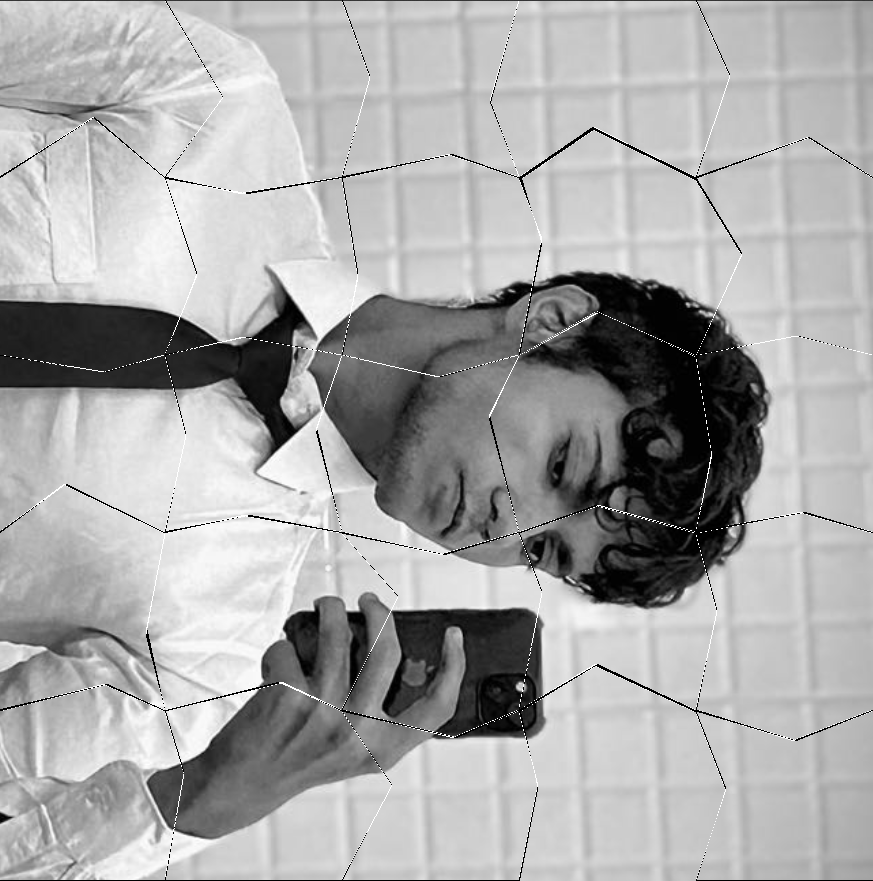

In [ ]:
solved_image1 = solve("priyank")

STARTING WITH SEED: 0
solved!


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


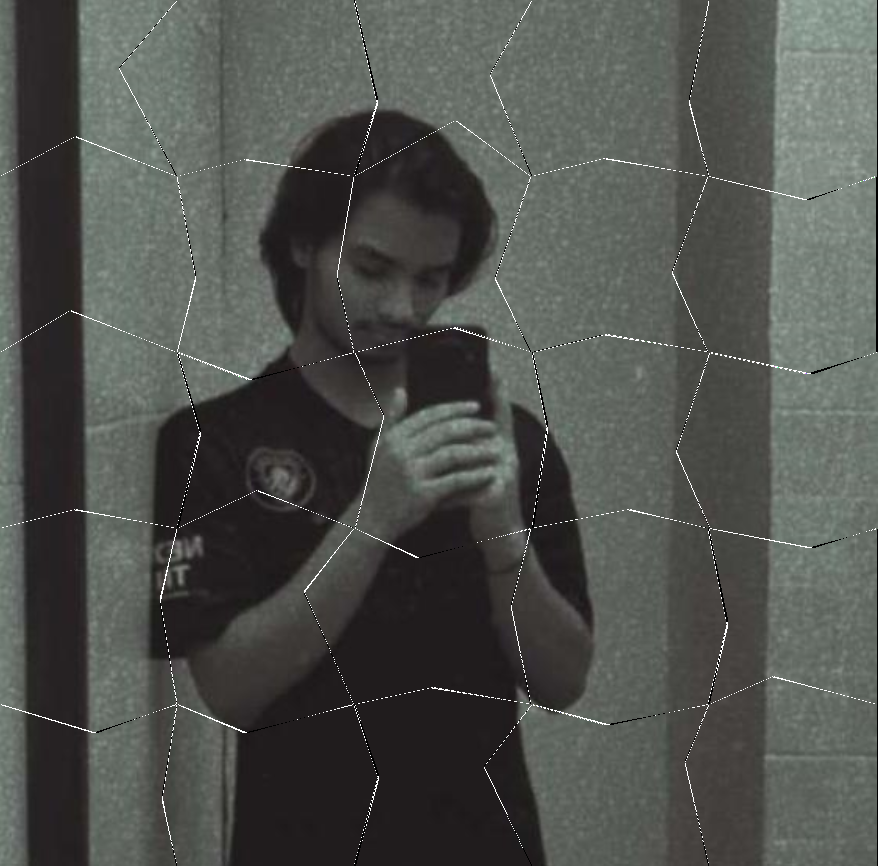

In [ ]:
creator = PuzzleCreator()
creator.create("shasha.png", name="shasha", grid_size=10)
solved_image2 = solve("shasha")

STARTING WITH SEED: 0
solved!


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


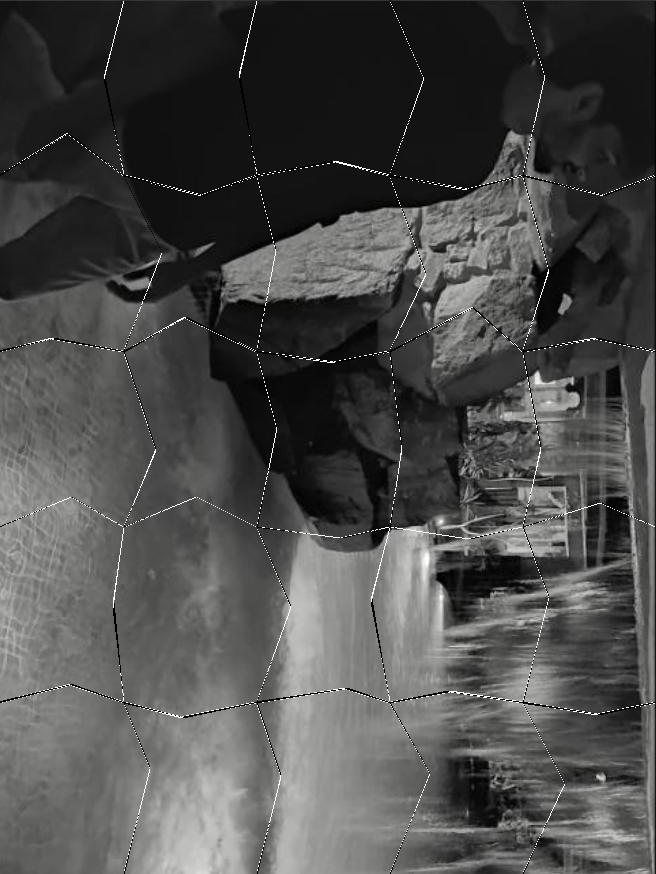

In [ ]:
creator = PuzzleCreator()
creator.create("rj.png", name="rj", grid_size=10)
solved_image3 = solve("rj")

STARTING WITH SEED: 0
Traceback (most recent call last):
  File "<ipython-input-24-b6fc5cb6fe78>", line 14, in solve
    row, col = find_next_piece(piece_info, edge_set, solution, row, col)
  File "<ipython-input-22-810a1cc64c35>", line 205, in find_next_piece
    next_piece.rotate(abs(3 - max_edge.side))
AttributeError: 'NoneType' object has no attribute 'rotate'

STARTING WITH SEED: 1
Traceback (most recent call last):
  File "<ipython-input-24-b6fc5cb6fe78>", line 14, in solve
    row, col = find_next_piece(piece_info, edge_set, solution, row, col)
  File "<ipython-input-22-810a1cc64c35>", line 205, in find_next_piece
    next_piece.rotate(abs(3 - max_edge.side))
AttributeError: 'NoneType' object has no attribute 'rotate'

STARTING WITH SEED: 2
solved!


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


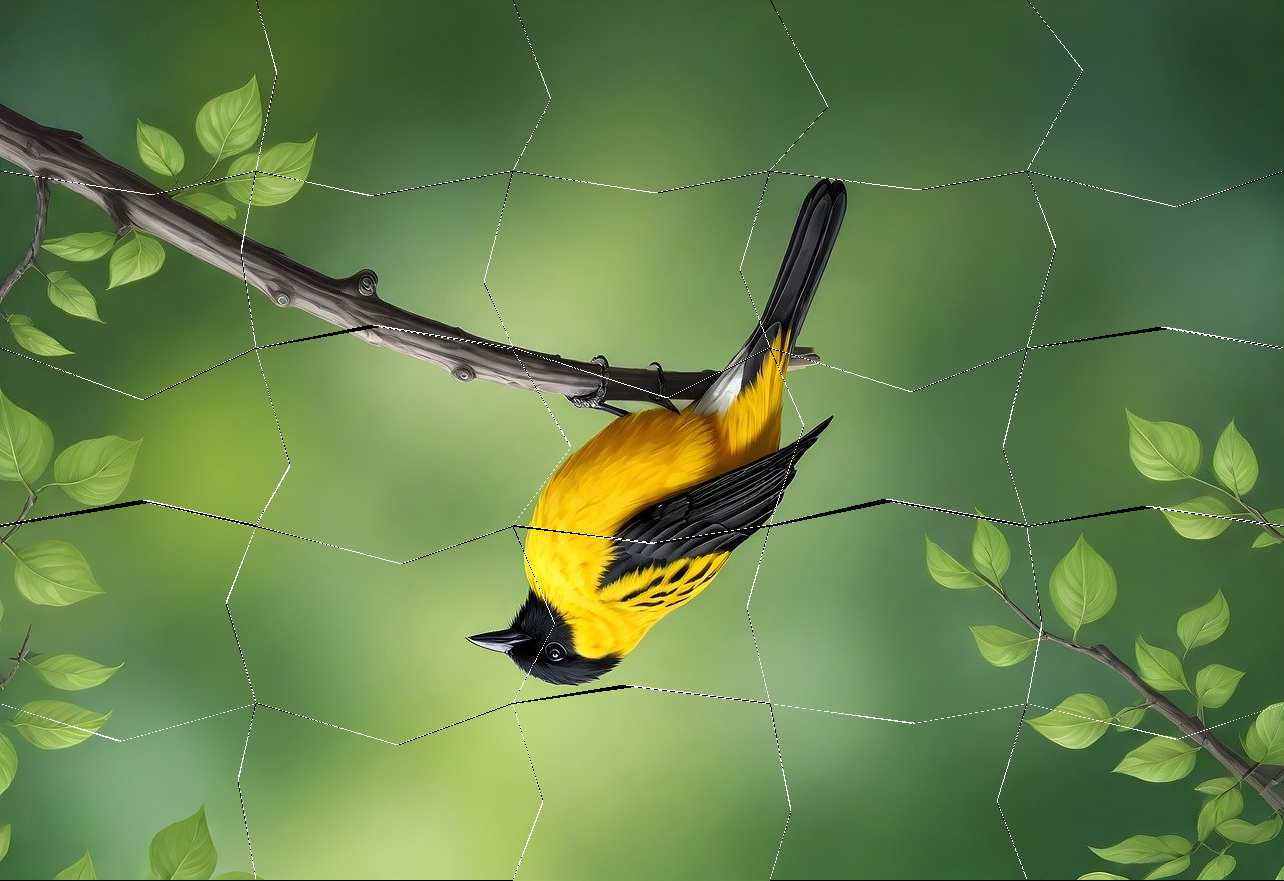

In [ ]:
creator = PuzzleCreator()
creator.create("pixbay1.png", name="pixbay1", grid_size=10)
solved_image4 = solve("pixbay1")

STARTING WITH SEED: 0
solved!


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


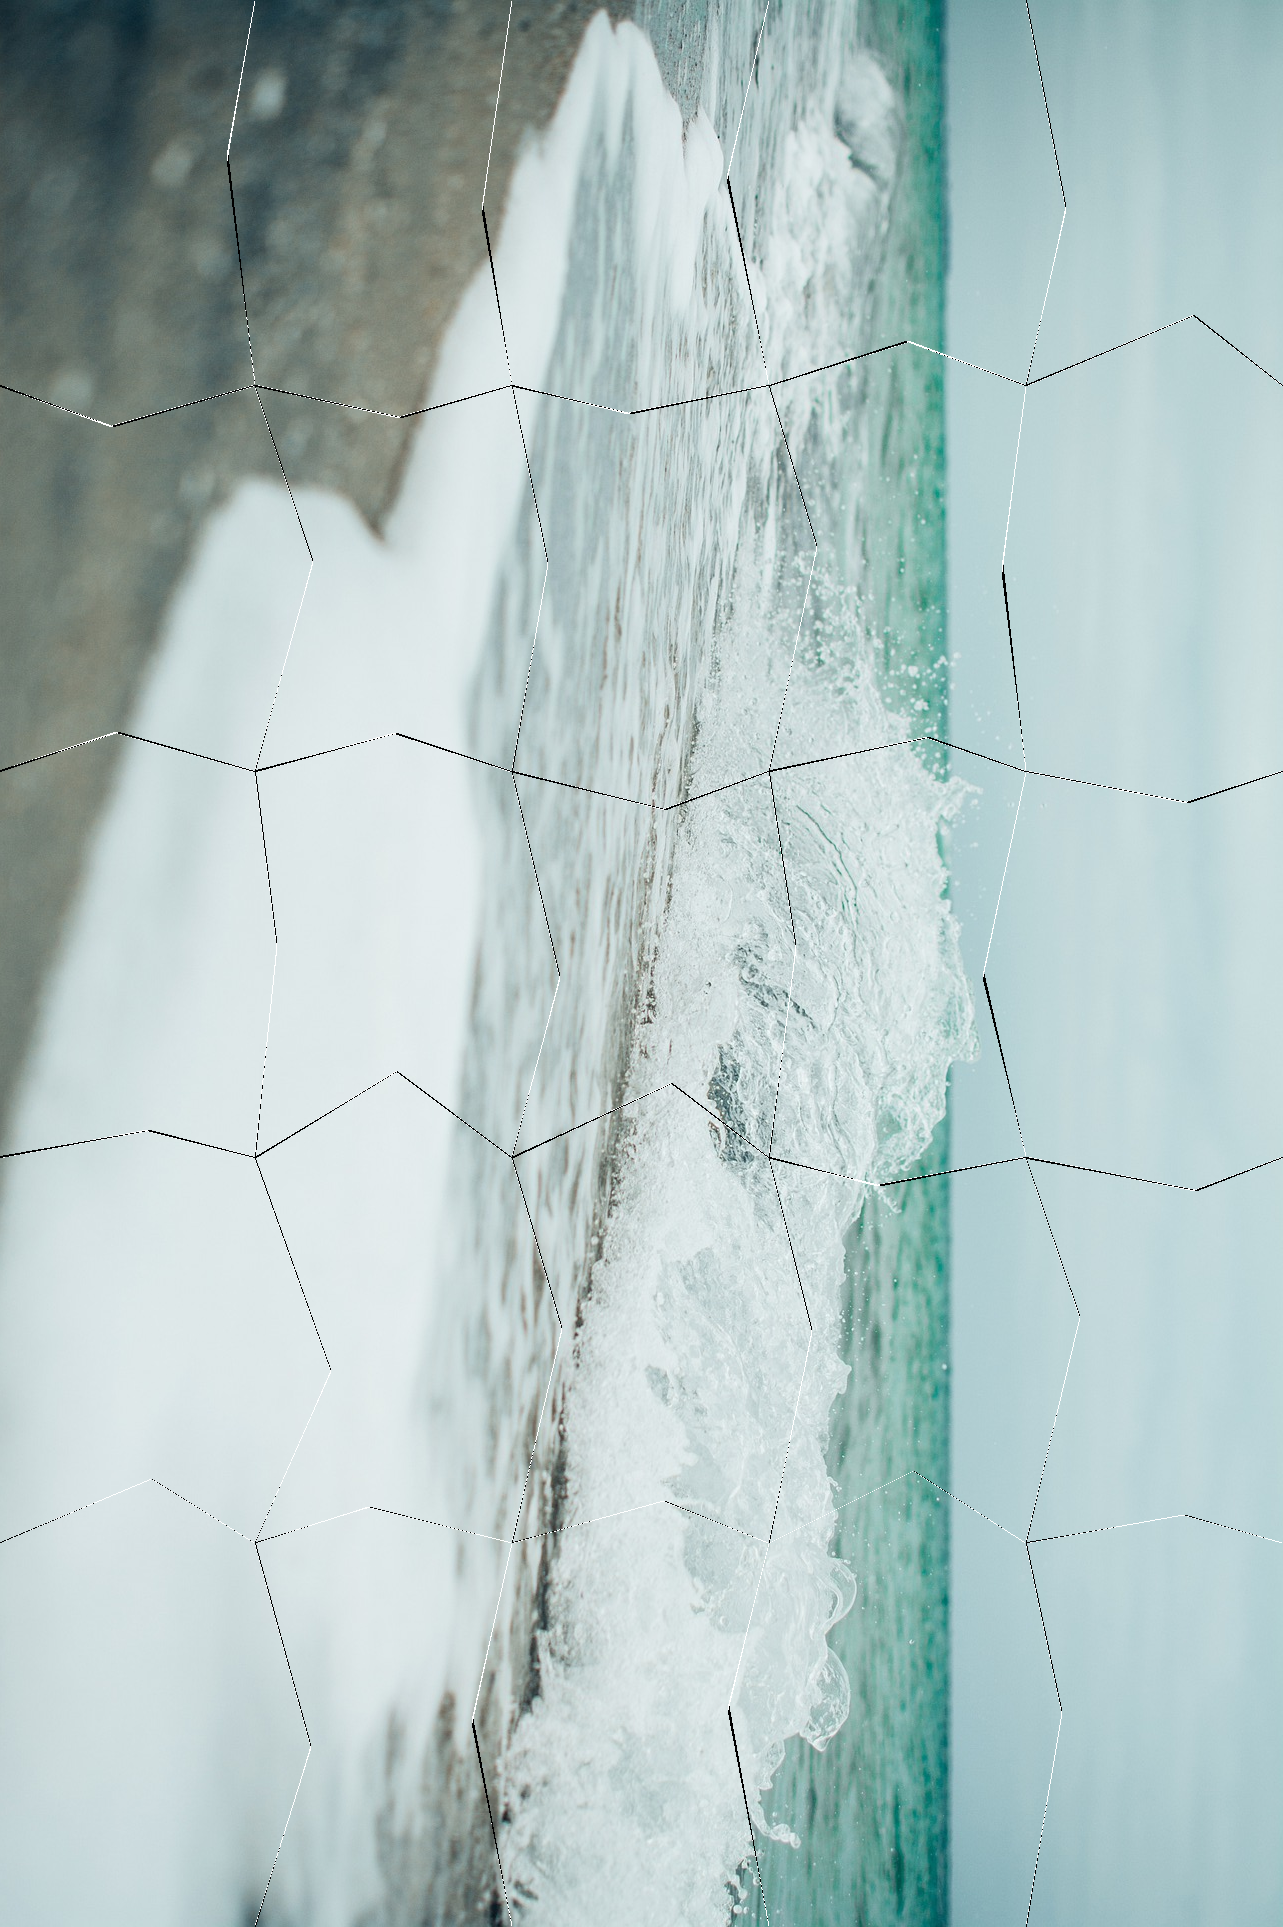

In [ ]:
creator = PuzzleCreator()
creator.create("pixbay2.jpg", name="pixbay2", grid_size=10)
solved_image5 = solve("pixbay2")

STARTING WITH SEED: 0
solved!


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


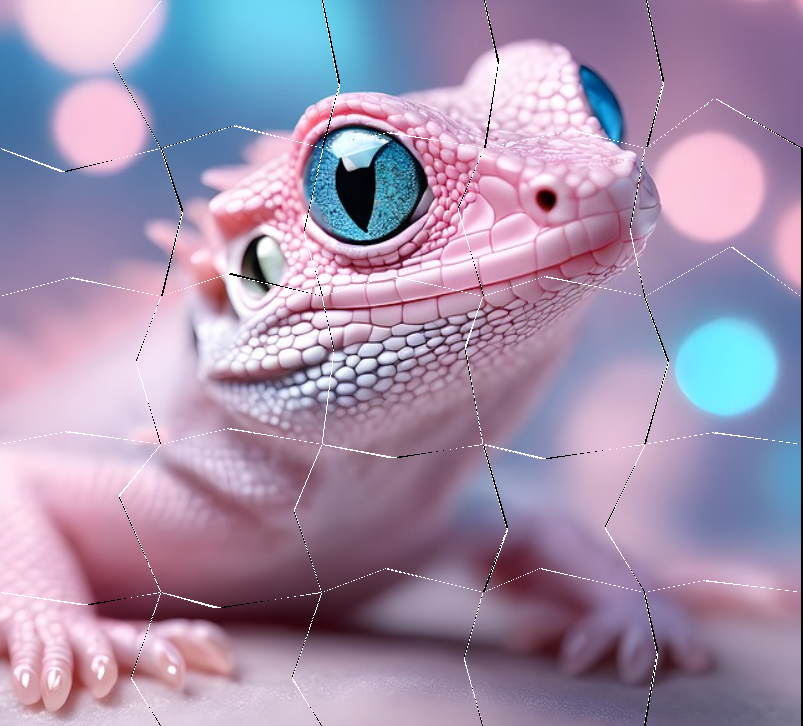

In [ ]:
creator = PuzzleCreator()
creator.create("pixbay3.png", name="pixbay3", grid_size=10)
solved_image5 = solve("pixbay3")